In [1]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from preprocessing import *
from split_data import *
from training_models import *
from load_models import *
import random
from load_data import *
from matplotlib.ticker import FormatStrFormatter
from GradCAM_1D import GradCAM
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize

In [63]:
path = 'the-circor-digiscope-phonocardiogram-dataset-1.0.3/training_data/' # this path is dataset path of PhysioNet 2022
wave_info, demo_info, outcomes, grade, paitnet_id = get_dataset(path)
train_x, test_x, train_outcome, test_outcome, train_demo, test_demo, train_grade, test_grade, fold, mur_list, train_id, test_id = get_split_for_murmurnet(
                                            wave_info, demo_info, outcomes, grade, paitnet_id, test_size = 0.2)

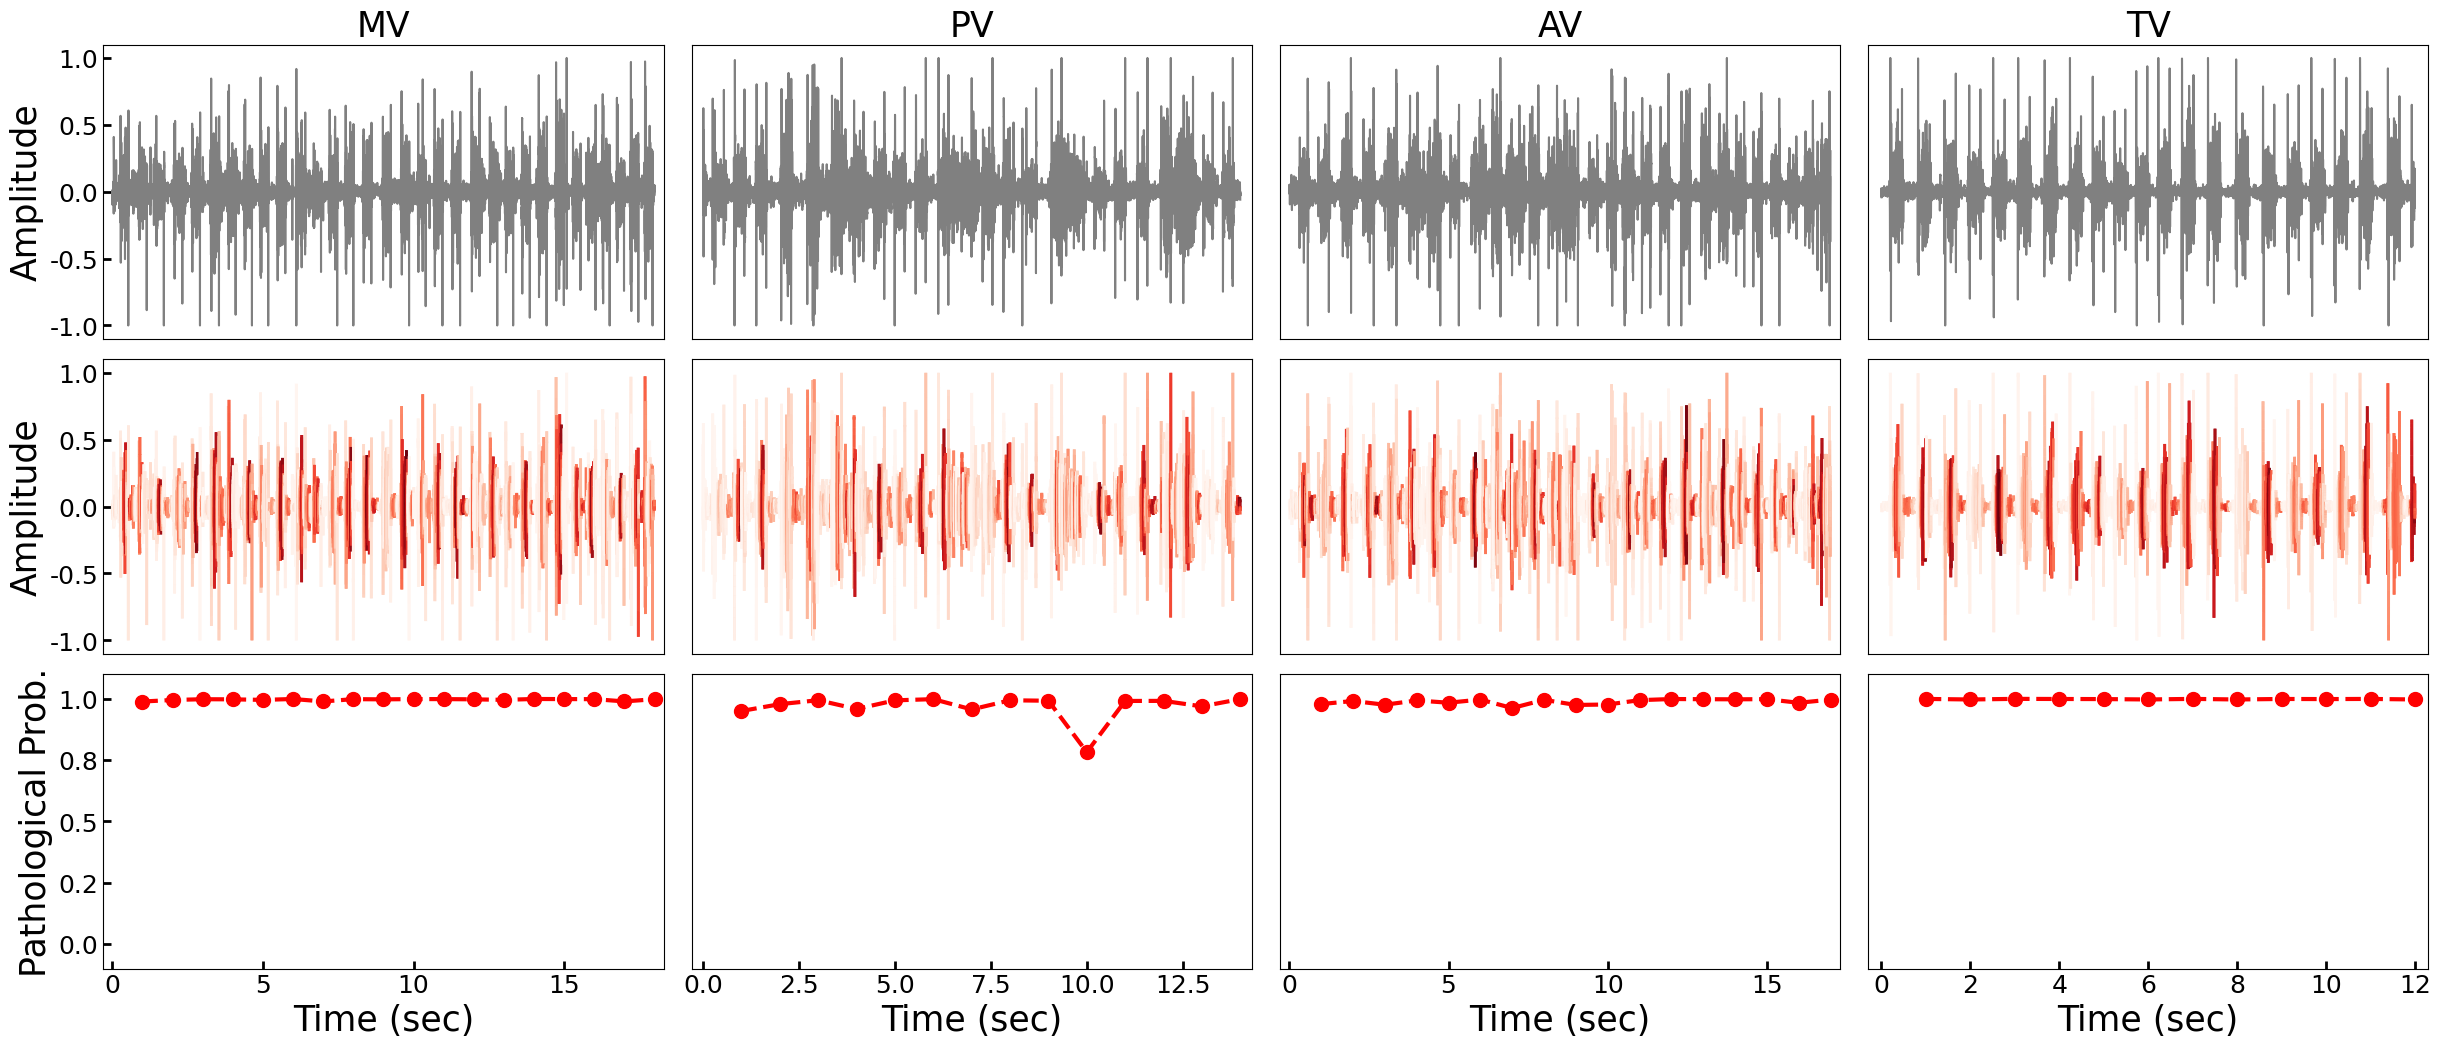

In [68]:
"""Load model"""
os.environ["CUDA_VISIBLE_DEVICES"] = str(0) # GPU number
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path = 'save_model.pt' # your saved model path

param_saved = torch.load(path, map_location = device)
test_model = load_model(model_name = 'tcn', n_ch = 1).to(device)
test_model.load_state_dict(param_saved)
test_model.eval()

target_layer = test_model.elu0 # last convloutionla layer
cam_net = GradCAM(test_model, target_layer) # GradCAM
""""""

i = 60 # index of test_id
patient_id = test_id[i].item().split('/')[-1][:-4]
current_patient = test_x[i].copy()
if len(current_patient) == 4:
    current_patient[0], current_patient[1], current_patient[2], current_patient[3] = current_patient[3], current_patient[1], current_patient[0], current_patient[2] # ordering channel MV, PV, AV, TV
    
plt.figure(figsize = (30,12))
for j in range(0, len(current_patient)):
    features = []
    loc_name = current_patient[j][2]
    if loc_name == 'Ph':
        continue
    loc_wave = current_patient[j][0]
    for n in range(0, len(loc_wave) - 4000, 4000): # 1 second sliding window
        features.append(get_wave_features(loc_wave[n: n + 4000], featuresFs = 2000)) # Preprocessing
    features = np.array(features)
    if len(features) != 0:
        features = features.reshape((len(features), 1, 2000))
        features = torch.Tensor(features)
        features = features.to(device).float()
        pred = test_model(features).cpu().detach().flatten().numpy() # segment-level prediction
    features = features.cpu().detach().numpy().squeeze()
    
    plt.subplot(3,4,j+1) # plotting PCG signal
    plt.plot(np.arange(0, len(features.flatten()))/2000, features.flatten(), color = 'grey')
    plt.title('{}'.format(loc_name), fontsize = 25)
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    if j == 0:
        plt.yticks(fontsize = 18)
        plt.ylabel('Amplitude', fontsize = 25)
    else:
        plt.yticks([])
    plt.xticks([])
    plt.xlim(0 - 0.3, (np.arange(0, len(features.flatten()))/2000)[-1] + 0.3  )
    plt.ylim(features.min() - 0.1, features.max() + 0.1)
    plt.tick_params(axis='y', labelsize=18, direction='in', width = 2, length = 6)
    plt.tick_params(axis='x', labelsize=18, direction='in', width = 2, length = 6)

    plt.subplot(3,4,9+j) # plotting Model prediction
    plt.plot(np.arange(1, len(pred)+1), pred, color = 'red', linewidth = 3, linestyle = '--')
    plt.scatter(np.arange(1, len(pred)+1), pred, color = 'red', s = 100)
    plt.ylim(-0.1, 1.1)
    if j == 0:
        plt.yticks(fontsize = 25)
        plt.ylabel('Pathological Prob.', fontsize = 25)
    else:
        plt.yticks([])
    plt.xticks(fontsize = 18)
    plt.xlabel('Time (sec)', fontsize = 25)
    plt.xlim(0 - 0.3, (np.arange(0, len(features.flatten()))/2000)[-1] + 0.3  )
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    plt.tick_params(axis='y', labelsize=18, direction='in', width = 2, length = 6)
    plt.tick_params(axis='x', labelsize=18, direction='in', width = 2, length = 6)

    # Segment-level prediction to record-level CAM visualization        
    temp_features = features.copy()
    grad = np.array([])
    for n in range(0, len(temp_features) - 1):        
        segment1 = torch.Tensor(temp_features[n].reshape((1, 1, 2000))).to(device).float()
        seg_grad1 = cam_net(segment1)
        grad = np.concatenate([grad, seg_grad1])
    grad = np.convolve(np.ones(40)/40, grad, mode = 'same') # Smoothness
    grad = (grad - np.min(grad))/(np.max(grad) - np.min(grad))

    plt.subplot(3,4,5+j) # Heatmap of CAM weight
    x = np.arange(0, len(features.flatten()))/2000
    y = features.flatten()
    colors = grad
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = Normalize(0, 1)
    lc = LineCollection(segments, cmap='Reds', norm=norm)
    lc.set_array(colors)
    lc.set_linewidth(2)
    plt.gca().add_collection(lc)
    plt.xlim(0 - 0.3, (np.arange(0, len(features.flatten()))/2000)[-1] + 0.3  )
    plt.ylim(y.min() - 0.1, y.max() + 0.1)
    # cbar = plt.colorbar(lc)
    # cbar.set_label("CAM weight", fontsize=18)
    # cbar.ax.tick_params(labelsize=15)
    # cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    plt.tick_params(axis='y', labelsize=18, direction='in', width = 2, length = 6)
    plt.tick_params(axis='x', labelsize=18, direction='in', width = 2, length = 6)
    if j == 0:
        plt.yticks(fontsize = 18)
        plt.ylabel('Amplitude', fontsize = 25)
    else:
        plt.yticks([])
    plt.xticks([])
    plt.subplots_adjust(hspace=0.07)
    plt.subplots_adjust(wspace=0.05)
    
    
# Saved figure
murmur_label = ''
outcome_label = ''
if test_grade[i] == 0:
    murmur_label = 'Absent'
elif test_grade[i] >= 1:
    murmur_label = 'Present'

if test_outcome[i] == 0:
    outcome_label = 'Normal'
elif test_outcome[i] == 1:
    outcome_label = 'Abnormal'
plt.savefig('patient_id_{}_{}_{}.svg'.format(patient_id, murmur_label, outcome_label), bbox_inches = 'tight')
plt.show()